In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import time

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
np.random.seed(42)

%matplotlib inline

In [58]:
TEST_SIZE = 0.1

In [59]:
%run 'Params.ipynb'

In [60]:
df = pd.read_csv('urban_sound.csv')

In [61]:
X = copy.copy(df.drop('class',axis=1))
y = copy.copy(df['class'])

In [62]:
grouped_counter = y.groupby(by=y).count()
grouped_counter

class
air_conditioner     600
car_horn            306
children_playing    600
dog_bark            600
drilling            600
engine_idling       624
gun_shot            230
jackhammer          668
siren               607
street_music        600
Name: class, dtype: int64

In [63]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pd.DataFrame(pca.fit_transform(X_norm))

In [64]:
df_pca = pd.concat([X_pca,y],axis=1)

<AxesSubplot:ylabel='Count'>

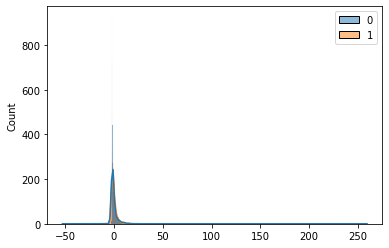

In [65]:
sns.histplot(df_pca,kde=True)

<AxesSubplot:ylabel='Count'>

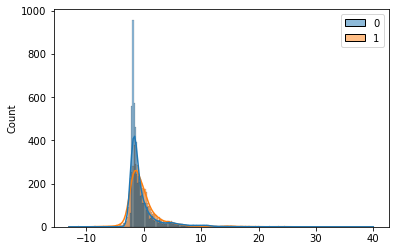

In [66]:
sns.histplot(df_pca[df_pca[0]<25],kde=True)

<AxesSubplot:ylabel='Count'>

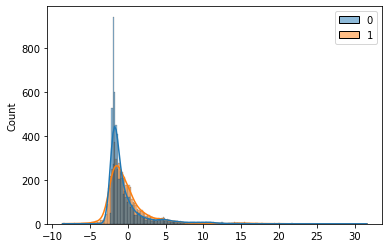

In [67]:
sns.histplot(df_pca[(df_pca[0]<15)&(df_pca[0]>-17)],kde=True)

<AxesSubplot:xlabel='0', ylabel='1'>

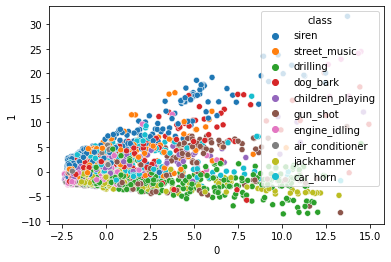

In [68]:
df_pca_without_outliers = df_pca[(df_pca[0]<15)&(df_pca[0]>-17)]
sns.scatterplot(data=df_pca_without_outliers,x=0,y=1,hue='class')

/home/nikola/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


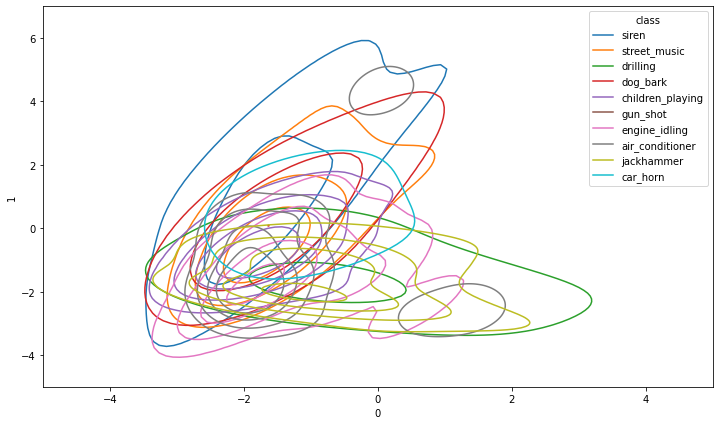

In [69]:
fig = plt.figure(figsize=(12,7))
g = sns.kdeplot(
    data=df_pca_without_outliers, x=0, y=1, hue="class",
    levels=5, thresh=.2
);
g.set(xlim=(-5, 5));
g.set(ylim=(-5, 7));

In [70]:
print(df_pca_without_outliers.groupby(by='class').count()[1] / grouped_counter)
print(sum(df_pca_without_outliers.groupby(by='class').count()[1])/sum(grouped_counter))

class
air_conditioner     1.000000
car_horn            0.996732
children_playing    0.998333
dog_bark            0.973333
drilling            0.961667
engine_idling       0.996795
gun_shot            0.986957
jackhammer          0.998503
siren               1.000000
street_music        0.998333
dtype: float64
0.9911683532658694


In [71]:
df_without_outliers = df.loc[df_pca_without_outliers.index]
X_without_outliers = df_without_outliers.drop('class',axis=1)
y_without_outliers = df_without_outliers['class']

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X_without_outliers, y_without_outliers, test_size=TEST_SIZE, random_state=41)

## Neural network classifier

In [ ]:
nn_hyperparameters = get_nn_hyperparams()

In [ ]:
nn_rgrid = RandomizedSearchCV(pipe_nn,cv=10, param_distributions=nn_hyperparameters,scoring='f1_micro', 
            n_jobs=4,n_iter=20)

In [ ]:
nn_rgrid.fit(X_train,y_train)

## Logistic regression

In [ ]:
lgr_hyperparameters = get_lgr_hyperparams()

In [ ]:
pipe_lgr = Pipeline(steps=[('scaler',StandardScaler()),('lgr', LogisticRegression())]) 

In [ ]:
lgr_rgrid = RandomizedSearchCV(pipe_lgr,cv=10, 
            param_distributions=lgr_hyperparameters,scoring='f1_micro', n_jobs=4
            ,n_iter=20)

In [ ]:
lgr_rgrid.fit(X_train,y_train)

## K nearest neighbors

In [ ]:
knn_hyperparameters = get_knn_hyperparams(df)

In [ ]:
pipe_knn = Pipeline(steps=[('scaler',StandardScaler()),('knn', KNeighborsClassifier())]) 

In [ ]:
knn_rgrid = RandomizedSearchCV(pipe_knn,cv=10, param_distributions=knn_hyperparameters,
                            scoring='f1_micro', n_jobs=4,n_iter=20)

In [ ]:
knn_rgrid.fit(X_train,y_train)

0.9736316204071045


## Neural network classifier with PCA

In [73]:
pipe_nn_pca = Pipeline(steps=[('scaler',StandardScaler()),('pca',PCA()),('mlp', MLPClassifier())]) 

In [74]:
nn_pca_hyperparameters = get_nn_pca_hyperparams()

In [75]:
nn_pca_rgrid = RandomizedSearchCV(pipe_nn_pca,cv=10, param_distributions=nn_pca_hyperparameters,scoring='f1_micro', n_jobs=4)

In [ ]:
nn_pca_rgrid.fit(X_train,y_train)

## Logistic regression with PCA

In [77]:
lgr_pca_hyperparameters = get_lgr_pca_hyperparams()

In [78]:
pipe_lgr_pca = Pipeline(steps=[('scaler',StandardScaler()),('pca',PCA()),('lgr', LogisticRegression())]) 

In [79]:
lgr_pca_rgrid = GridSearchCV(pipe_lgr_pca,cv=10, param_distributions=lgr_pca_hyperparameters,scoring='f1_micro', n_jobs=4)

In [ ]:
lgr_pca_rgrid.fit(X_train,y_train)

## K nearest neighbors with PCA

In [81]:
knn_pca_hyperparameters = get_knn_pca_hyperparams(df)

In [82]:
pipe_knn_pca = Pipeline(steps=[('scaler',StandardScaler()),('pca',PCA()),('knn', KNeighborsClassifier())]) 

In [83]:
knn_pca_rgrid = GridSearchCV(pipe_knn_pca,cv=10, param_distributions=knn_pca_hyperparameters,scoring='f1_micro', n_jobs=4)

In [84]:
knn_pca_rgrid.fit(X_train,y_train)

1.514220952987671


# Predictions

In [ ]:
nn_rgrid.score(X_test,y_test)

0.7101390024529844

In [ ]:
lgr_rgrid.score(X_test,y_test)

0.6289860997547015

In [ ]:
knn_rgrid.score(X_test,y_test)

0.5999591169255928

In [85]:
nn_pca_rgrid.score(X_test,y_test)

0.7256745707277187

In [86]:
lgr_pca_rgrid.score(X_test,y_test)

0.5993458708094849

In [87]:
knn_pca_rgrid.score(X_test,y_test)

0.6813164349959117